# Cross-Entropy Method with adapting level of exploration

install necessary packages

In [ ]:
!apt-get update
!apt-get install xvfb
!apt-get install x11-utils
!apt-get install ffmpeg
!apt-get install python-opengl
!pip -q install gym pyvirtualdisplay pygame
!pip3 install box2d-py

# Environment
import gym # OpenAI gym
import math
import frogger_env
gym.logger.set_level(40) # suppress warnings on gym

# Models and computation
import torch # will use pyTorch to handle NN
#from torch.distributions import Normal
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque
import random
from random import sample

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

# IO
from pathlib import Path
import os


Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.co

# Test out things

In [ ]:
display = Display(visible=0, size=(600, 400))
display.start()

#Let's define a simple helper function for visualization of episodes
def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay
                      controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [ ]:
env = gym.make("reacher-v0")
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False
while not done:
    action = 1
    obs, reward, done, info = env.step(action)
env.close()
show_video('./video')

Origin:  [0.0, 0.0]
world_width:  50.0
world_height:  50.0
Screen:  <Surface(600x600x32 SW)>


In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)


observation space: Box(0.0, 1.0, (6,), float32)
action space: Discrete(4)


# CEM with adapting the level of exploration

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Simple NN with one hidden layers
class CEMNetwork(nn.Module):
    def __init__(self, s_size,  a_size, fc_units=16):
        """Initializing the network."""
        super(CEMNetwork, self).__init__()
        self.env = env
        # save values for use in set weights
        self.s_size = s_size
        self.fc_units = fc_units
        self.a_size = a_size
        # 1 hidden layer with 16 nodes
        self.fc1 = nn.Linear(self.s_size, self.fc_units)
        self.fc2 = nn.Linear(self.fc_units, self.a_size)

    def forward(self, state):
        """Perform forward propagation."""

        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             device=device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def set_weights(self, weights):
        """
        Sets the weight of the network using an incoming weight
        algorithm referenced from https://github.com/udacity/deep-reinforcement-learning/blob/master/cross-entropy/CEM.ipynb
        """
        s_size = self.s_size
        fc_units = self.fc_units
        a_size = self.a_size

        fc1_end = (s_size*fc_units)+fc_units
        fc1_W = torch.from_numpy(weights[:s_size*fc_units].reshape(s_size, fc_units))
        fc1_b = torch.from_numpy(weights[s_size*fc_units:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(fc_units*a_size)].reshape(fc_units, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(fc_units*a_size):])

        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))

    def get_weights_dim(self):
        """
        Returns the number of the NN parameters (weights, biases)
        """
        return sum(p.numel() for p in self.parameters())

In [ ]:
class CEMAgent():
    def __init__(self):
        """
        Initialize a CEMAgent object.
        """
        self.env = env
        self.steps = 0
        self.network = CEMNetwork(env.observation_space.shape[0], env.action_space.n, 16).to(device)

    def greedy_action(self, state):
        """
        Returns the greedy action.

        Params
        ======
            state (array_like): current state
        """
        with torch.no_grad():
            q_values = self.network(state).cpu().detach().data.numpy().squeeze()
        return np.argmax(q_values)


    def evaluate(self, weights, gamma, n_rollouts=1):
        """
        Returns the mean reward obtained by executing the greedy policy for a fixed number of rollouts.

        Params
        ======
            weights: best weight while evaluating, or current weight during perturbation
            gamma:  discount factor
            n_rollouts (int): the number of rollouts to be performed
        """
        self.network.set_weights(weights)
        episode_return = []
        for _ in range(n_rollouts):
            state, done = self.env.reset(), False
            episode_return.append(0.0)
            exp_eval = 0
            while not done:
                state = torch.from_numpy(state).float().to(device)
                action = self.greedy_action(state)
                state, reward, done, _ = self.env.step(action)
                episode_return[-1] += reward * math.pow(gamma, exp_eval)
                exp_eval += 1
            self.steps += exp_eval
        return np.mean(episode_return)

    def train(self, n_iterations, gamma, pert, top_k, sigma, seed, mean):
        """
        Training the agent.
        Returns a list of (average evaluation reward over last 10 episodes, total number of steps)

        Params
        ======
            n_iterations (int): max number of iterations
            gamma (float): the discount factor
            pert (int): number of perturbations
            top_k (float): % of top k weights
            sigma (float): standard deviation
            mean (float): mean
            seed (int): a random of fixed seed number
        """
        self.seed = seed
        self.mean = mean
        self.sigma = sigma
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)

        top_n=int(pert*top_k)

        scores_deque = deque(maxlen=10)
        scores = np.empty((n_iterations, 2))
        scores[:] = np.nan
        best_weight = np.zeros(self.network.get_weights_dim())                  # create inital random weight distribution
        self.mean = torch.tensor(np.ones(self.network.get_weights_dim())*self.mean)
        self.sigma = torch.tensor(np.ones(self.network.get_weights_dim())*self.sigma)

        for i_iteration in range(1, n_iterations+1):
            # use this function to create perturbations.
            random_weights = [np.array(torch.normal(mean=self.mean, std=(self.sigma))) for i in range(pert)]

            rewards = np.array([self.evaluate(weights, gamma) for weights in random_weights])    # calculate rewards for each perturbation

            # selecting top k weights
            top_idx = rewards.argsort()[-top_n:]                             # collect indexes of top k rewards
            top_weights = [random_weights[i] for i in top_idx]                # collect the weights using above indexes

            # calculating mean and std for next perturbation
            self.mean = torch.tensor(np.mean(top_weights, axis=0))            # calculate mean of all best weights (for each weight/bias location) and store as tensor of shape weights
            self.sigma = torch.tensor(np.std(top_weights, axis=0))            # calculate std of all best weights (for each weight/bias location) and store as tensor of shape weights

            # calculate best weight
            best_weight = np.array(top_weights).mean(axis=0)                  # calculate mean of top k weights

            # calculate evaluation rewards with 3 rollouts
            reward = self.evaluate(best_weight, gamma, 3)
            scores_deque.append(reward)
            scores[i_iteration-1] = reward, self.steps

            print('Iteration {}\tEvaluation Score: {:.2f}\tAvg. Evaluation Score: {:.2f}\tSteps: {}'.format(i_iteration, reward, np.mean(scores_deque), self.steps))

        save_checkpoint(self.network,'cem_domini4_'+str(seed)+'.pt',1)
        return scores

In [ ]:
from google.colab import drive
from google.colab import files

def save_checkpoint(model, filename, mode=0):
    """
    Save a model to a file in your colab space

    Parameters
    ----------
    model: your Q network
    filename: the name of the checkpoint file
    mode (int): determines where to store the file
                --> 0: collab space 1: Google Drive
    """
    if mode == 1:
      drive.mount('/content/gdrive')
      path = F"/content/gdrive/My Drive/{filename}"
      torch.save(model.state_dict(), path)
    else:
      torch.save(model.state_dict(), filename)

def export_to_local_drive(filename):
    """
    Download a file to your local machine

    Parameters
    ----------
    filename: the name of the file
    """
    files.download(filename)

In [ ]:
env = gym.make("reacher-v0")
max_iterations = 50
gamma = 0.999
perturbations = 50
top_k = 0.1
sigma = 1.0
mean = 0

seed = 1
env.seed(seed)
cem_agent_1 = CEMAgent()
scores_1 = cem_agent_1.train(max_iterations, gamma, perturbations, top_k, sigma, seed, mean)

seed = 5
env.seed(seed)
cem_agent_10 = CEMAgent()
scores_10 = cem_agent_10.train(max_iterations, gamma, perturbations, top_k, sigma, seed, mean)

seed = 12
env.seed(seed)
cem_agent_12 = CEMAgent()
scores_12 = cem_agent_12.train(max_iterations, gamma, perturbations, top_k, sigma, seed, mean)


Iteration 1	Evaluation Score: -0.30	Avg. Evaluation Score: -0.30	Steps: 846
Iteration 2	Evaluation Score: -0.30	Avg. Evaluation Score: -0.30	Steps: 1710
Iteration 3	Evaluation Score: -0.30	Avg. Evaluation Score: -0.30	Steps: 2533
Iteration 4	Evaluation Score: -0.30	Avg. Evaluation Score: -0.30	Steps: 3810
Iteration 5	Evaluation Score: -0.30	Avg. Evaluation Score: -0.30	Steps: 4800
Iteration 6	Evaluation Score: -0.46	Avg. Evaluation Score: -0.33	Steps: 5690
Iteration 7	Evaluation Score: 0.02	Avg. Evaluation Score: -0.28	Steps: 6993
Iteration 8	Evaluation Score: -0.31	Avg. Evaluation Score: -0.28	Steps: 8454
Iteration 9	Evaluation Score: 0.04	Avg. Evaluation Score: -0.24	Steps: 9275
Iteration 10	Evaluation Score: 0.04	Avg. Evaluation Score: -0.22	Steps: 10108
Iteration 11	Evaluation Score: 0.04	Avg. Evaluation Score: -0.18	Steps: 10692
Iteration 12	Evaluation Score: 0.04	Avg. Evaluation Score: -0.15	Steps: 11464


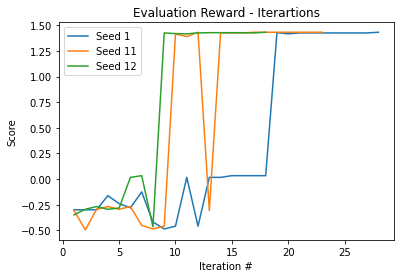

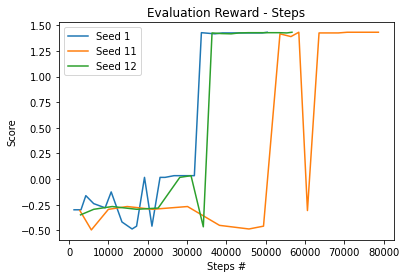

In [ ]:
# plot the scores
plt_scores_1, plt_steps_1 = scores_1.T
plt_scores_11, plt_steps_11 = scores_10.T
plt_scores_12, plt_steps_12 = scores_12.T

fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(np.arange(1, len(plt_scores_1)+1), plt_scores_1, label='Seed 1')
plt.plot(np.arange(1, len(plt_scores_11)+1), plt_scores_11, label='Seed 5')
plt.plot(np.arange(1, len(plt_scores_12)+1), plt_scores_12, label='Seed 12')
plt.ylabel('Score')
plt.xlabel('Iteration #')
leg = plt.legend();
ax1.set_title('Evaluation Reward - Iterartions')
#plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(111)
plt.plot(plt_steps_1, plt_scores_1, label='Seed 1')
plt.plot(plt_steps_11, plt_scores_11, label='Seed 5')
plt.plot(plt_steps_12, plt_scores_12, label='Seed 12')
plt.ylabel('Score')
plt.xlabel('Steps #')
leg = plt.legend();
ax2.set_title('Evaluation Reward - Steps')
plt.show()

In [ ]:
display = Display(visible=0, size=(600, 400))
display.start()

#Let's define a simple helper function for visualization of episodes
def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay
                      controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [ ]:
env = gym.make('reacher-v0')
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
state = env.reset()
done = False
rev = 0
while not done:
    action = cem_agent_1.greedy_action(state)
    state, reward, done, _ = env.step(action)
    rev += reward
print(rev)
env.close()
show_video('./video')

del env

Origin:  [0.0, 0.0]
world_width:  50.0
world_height:  50.0
Screen:  <Surface(600x600x32 SW)>
1.4336206947403212
